# 4. Time-varying beta functions

Far from being limited to static beta values, we can also simulate the affects of a time-and-location-varying beta function. For this demo, we'll use the State-level GEO we defined in Part 2.

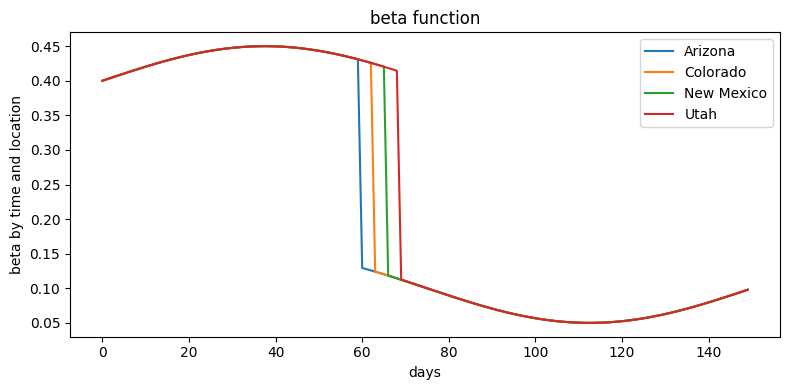

In [1]:
from functools import partial
from math import pi, sin

import matplotlib.pyplot as plt

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.initializer import single_location

# Our function will be a sinusoid with a precipitous drop after 60 days,
# staggered by 3 days for each location.


def beta_fn(t, n):
    # The arguments of this function are "t" -- the current simulation day,
    # and "n" the current geo node.
    # This formuluation allows us to vary the parameter over time and geo node.
    value = 0.40 + 0.05 * sin(2 * pi * t / dim.days)
    cutoff = 60 + (n * 3)
    if t >= cutoff:
        value -= 0.30
    return value


geo = load_from_cache('demo-four-states')
if geo is None:
    raise Exception(
        "Can't load the demo-four-states geo from cache; see demo part 2 for that.")

# Now we create a simulation, passing in our beta function.
sim = StandardSimulation(
    geo=geo,
    ipm=ipm_library['sirh'](),
    mm=mm_library['pei'](),
    params={
        'beta': beta_fn,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'move_control': 0.9,
        'theta': 0.1,
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    initializer=partial(single_location, location=0, seed_size=10_000)
)

# And now plot the beta function.
# If we want, we can ask the simulation for the full computed data series for beta.
# This way we can be sure we're plotting beta exactly as the simulation will see it.
beta_values = sim.params['beta']
fig, ax = plt.subplots(figsize=(8, 4))
ax.set(title='beta function', ylabel='beta by time and location', xlabel='days')
ax.plot(beta_values, label=geo['label'])
ax.legend()
fig.tight_layout()
plt.show()

Running simulation (StandardSimulation):
• 2015-01-01 to 2015-05-31 (150 days)
• 4 geo nodes
|####################| 100% 
Runtime: 0.239s


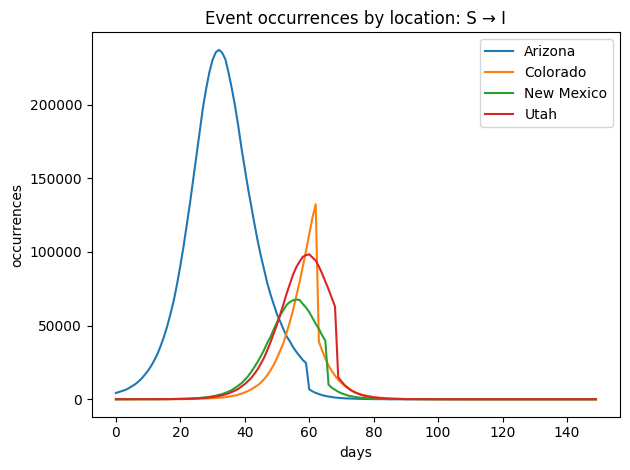

In [2]:
from epymorph import *

# Nothing changed from the simulation we declared above, so let's use that to run it.
with sim_messaging(sim):
    output = sim.run()

EVENT_S_TO_I = 0

plot_event(output, event_idx=EVENT_S_TO_I)